
# Local


In [1]:
! pip install --quiet -r ../requirements.txt

import sys
import os
sys.path.append(os.path.expanduser("~/repos/NeurOps/pytorch"))

# Colab


In [2]:
# ! git clone https://github.com/SuReLI/NeurOps.git
# ! git clone https://github.com/k8lion/GrowAndPrune.git
# %cd GrowAndPrune
# ! git pull
# %cd src
# ! pip install --quiet -r ../requirements.txt
# ! mkdir ../../data
# ! wget --no-check-certificate -O ../../data/Galaxy10_DECals.h5 https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

# import sys
# import os
# sys.path.append("../../NeurOps/pytorch")

# Imports

In [3]:
import numpy as np
import torch
import copy
import math
import matplotlib.pyplot as plt
from collections import OrderedDict

from neurops import *

from growprune import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/users/p21001/maile/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
# ! wget -O ../../data/vgg11-8a719046.pth https://download.pytorch.org/models/vgg11-8a719046.pth 

In [5]:
copy_linear = False
limit = 15 if not copy_linear else 19
model = ModVGG11(num_classes=10, avgpooldim=1, debug=False).to(device)
weights = torch.load("../../data/vgg11-8a719046.pth")
renamed = OrderedDict()
for i, (key, value) in enumerate(zip(model.state_dict(), weights.values())):
    if i <= limit:
        renamed[key] = value
    else:
        renamed[key] = model.state_dict()[key]
model.load_state_dict(renamed)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [6]:
train_loader, validation_loader, test_loader = get_galaxy10_dataloaders(path_to_dir="../..", batch_size=-1, dim=64)

In [7]:
# test = torch.randn(1, 3, 64, 64).to(device)
# for layer in model:
#     test = layer(test)
#     print(test.shape)

In [9]:
test(model, validation_loader, criterion, device=device)
test(model, train_loader, criterion, device=device)
init_score = np.zeros(len(model.activations))
for i in range(len(model)-1):
    tensor = model.activations[str(i)]
    print(torch.transpose(torch.transpose(tensor, 0, 1).reshape(tensor.shape[1], -1), 0, 1).shape)
    init_score[i] = effective_rank(model.activations[str(i)], limit_ratio = 10)
    print(f"Layer {i} has effective rank {init_score[i]}")

train(model, train_loader, optimizer, criterion, epochs=1, val_loader=validation_loader, device=device, verbose=True)

Average loss: 0.0714, Accuracy: 177/1596 (11.09%)
Average loss: 0.0712, Accuracy: 1605/14367 (11.17%)
torch.Size([131072, 64])
Layer 0 has effective rank 64.0
torch.Size([65536, 128])
Layer 1 has effective rank 127.0
torch.Size([131072, 256])
Layer 2 has effective rank 256.0
torch.Size([32768, 256])
Layer 3 has effective rank 256.0
torch.Size([65536, 512])
Layer 4 has effective rank 510.0
torch.Size([16384, 512])
Layer 5 has effective rank 505.0
torch.Size([16384, 512])
Layer 6 has effective rank 487.0
torch.Size([1024, 512])
Layer 7 has effective rank 361.0
torch.Size([8192, 4096])
Layer 8 has effective rank 2948.0
torch.Size([8192, 4096])
Layer 9 has effective rank 2676.0
Train Epoch: 0 [0/15963 (0%)]	Loss: 2.310325
Train Epoch: 0 [1600/15963 (11%)]	Loss: 1.517419
Train Epoch: 0 [3200/15963 (22%)]	Loss: 1.206226
Train Epoch: 0 [4800/15963 (33%)]	Loss: 1.048890
Train Epoch: 0 [6400/15963 (45%)]	Loss: 1.158559
Train Epoch: 0 [8000/15963 (56%)]	Loss: 0.862356
Train Epoch: 0 [9600/15963 

([0.0286548877494377], [0.6911027568922306], None)

In [10]:
test(model, validation_loader, criterion, device=device)


Average loss: 0.0287, Accuracy: 1103/1596 (69.11%)


(0.028693521045204392, 0.6911027568922306)

torch.Size([0, 1]) torch.Size([0, 1])
torch.Size([0, 1]) torch.Size([127, 1])
torch.Size([0, 1]) torch.Size([0, 1])
torch.Size([0, 1]) torch.Size([0, 1])
torch.Size([0, 1]) torch.Size([0, 1])
torch.Size([0, 1]) torch.Size([2038, 1])
torch.Size([0, 1]) torch.Size([511, 1])
torch.Size([0, 1]) torch.Size([2545, 1])
torch.Size([0, 1]) torch.Size([0, 1])
torch.Size([0, 1]) torch.Size([3382694, 1])


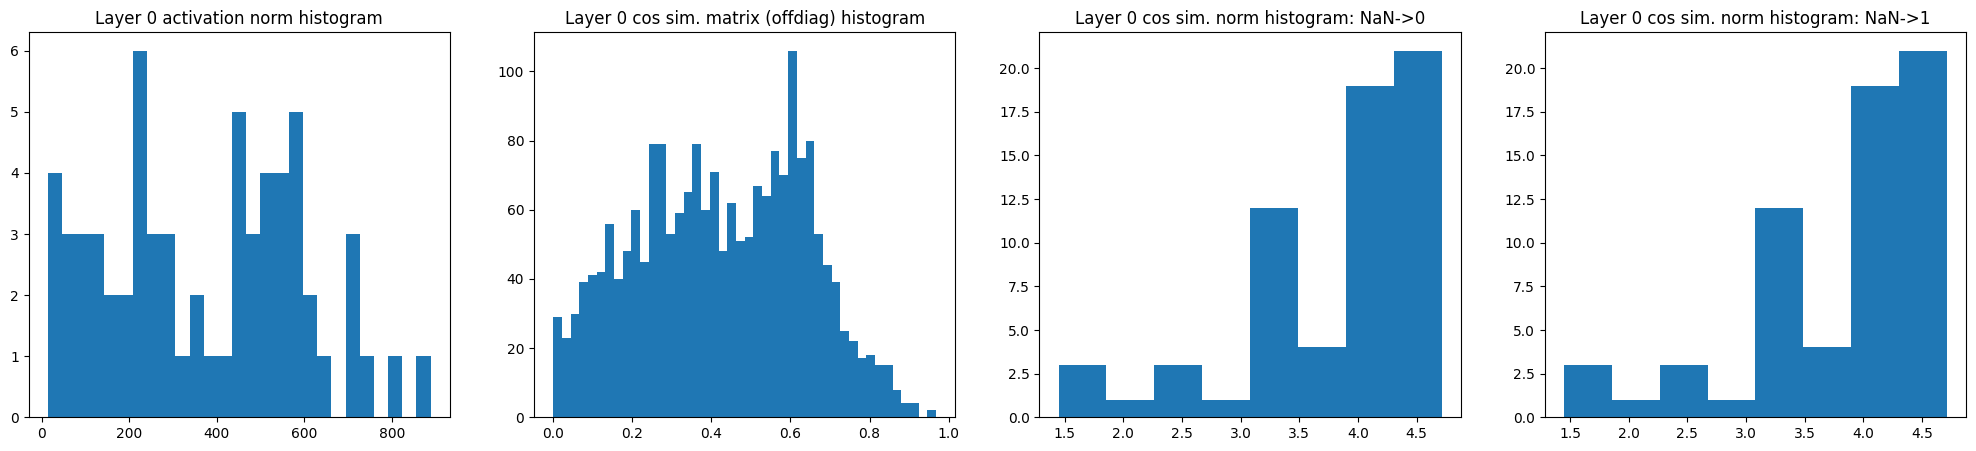

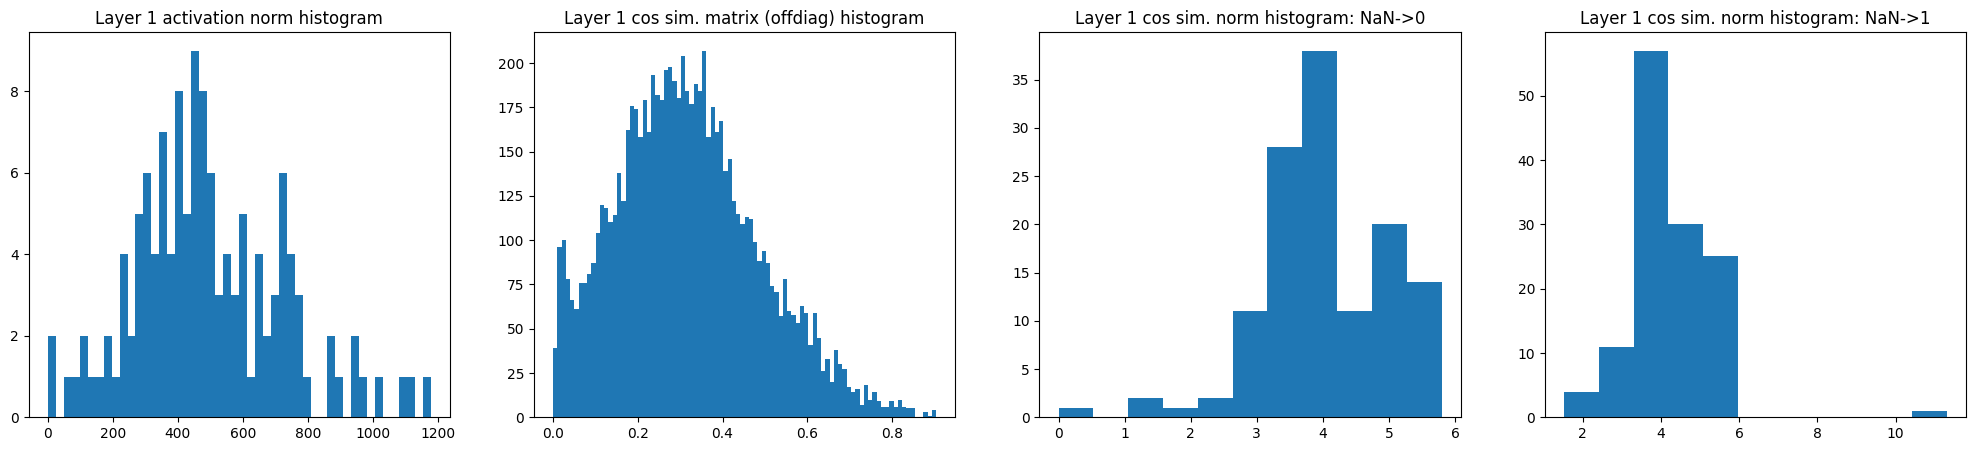

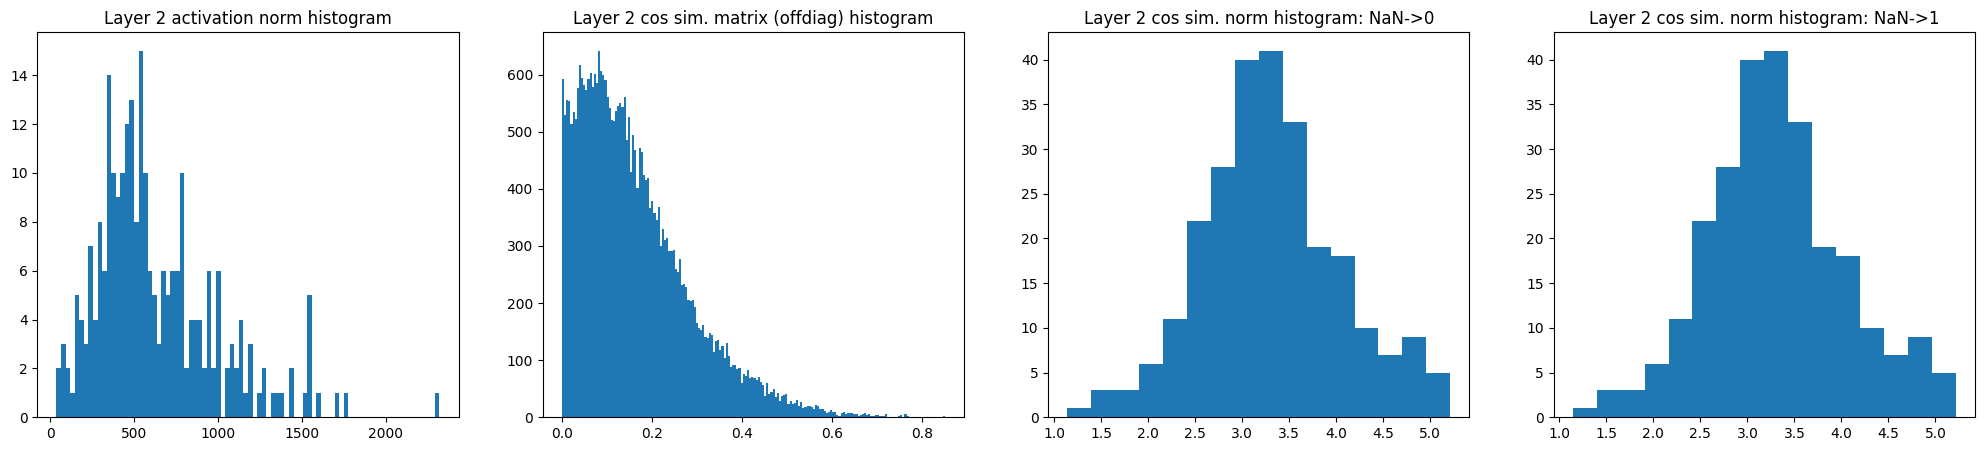

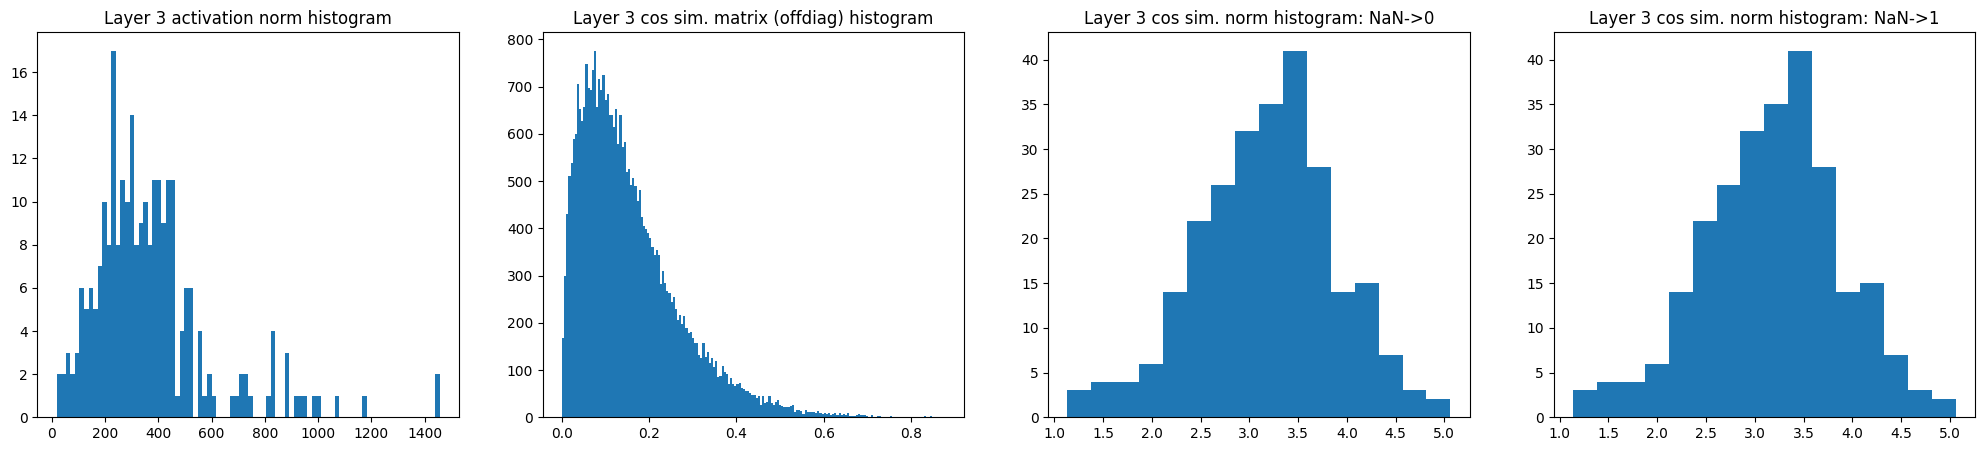

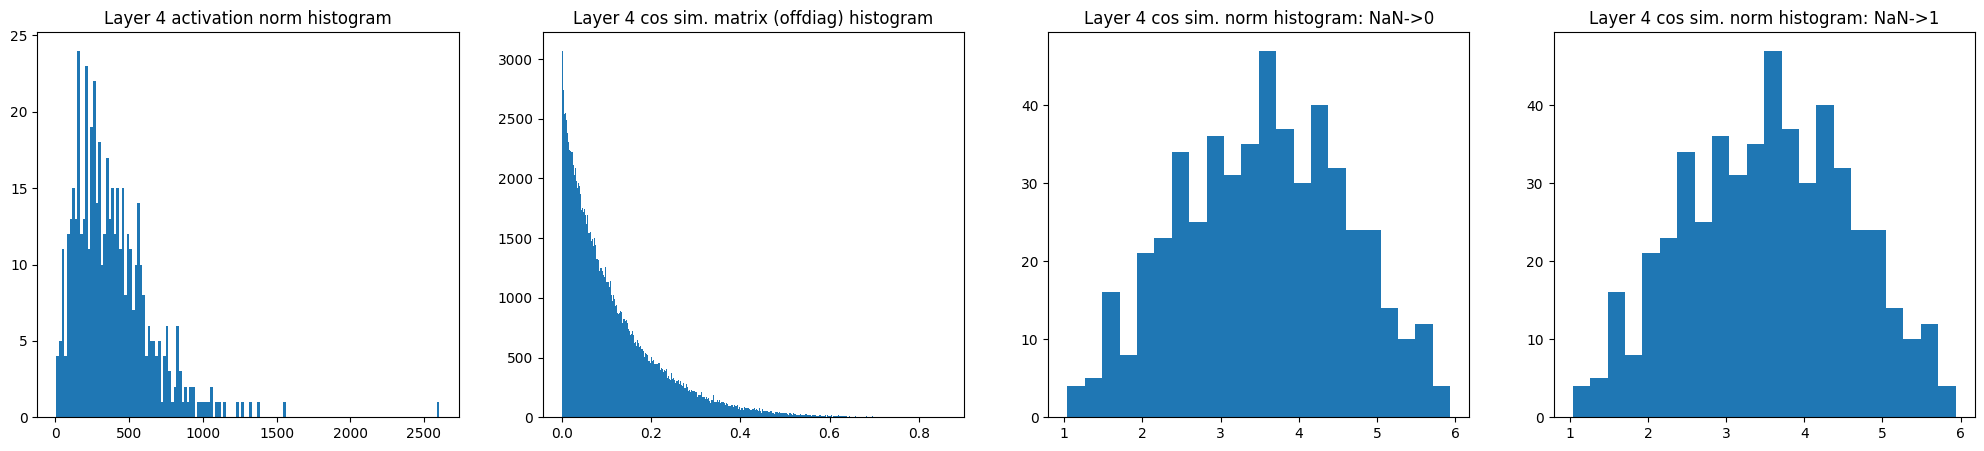

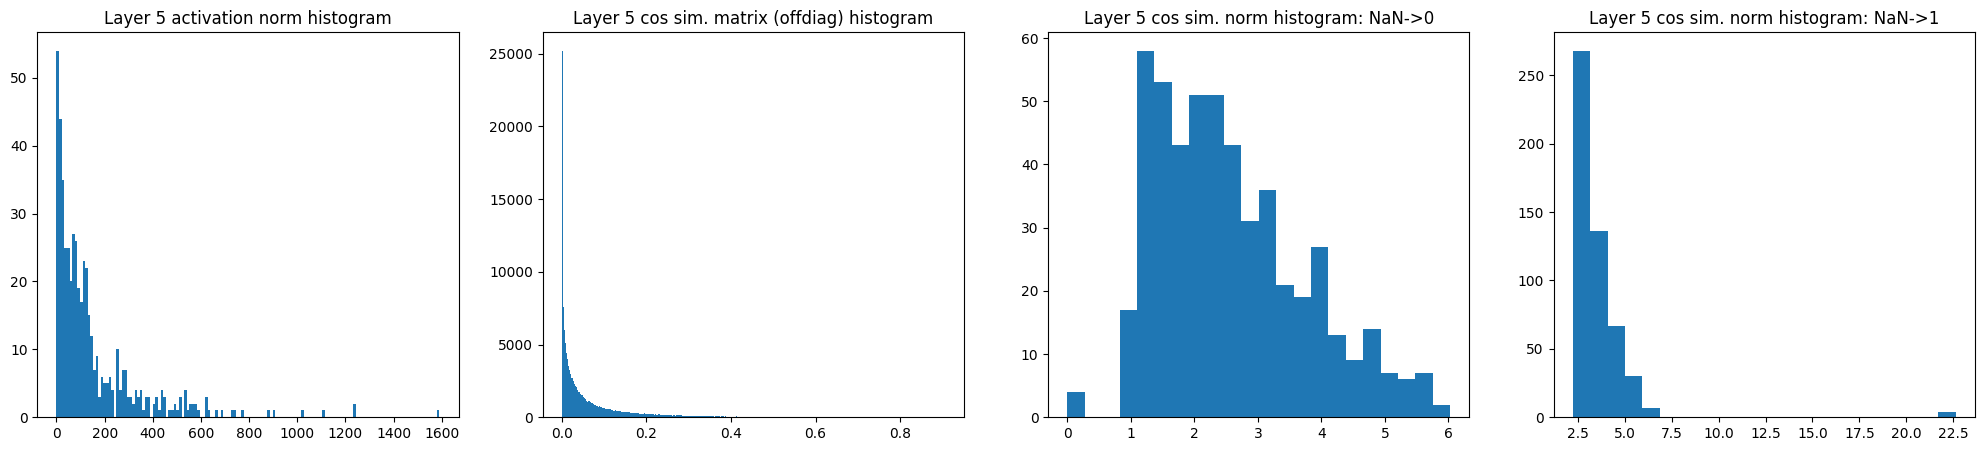

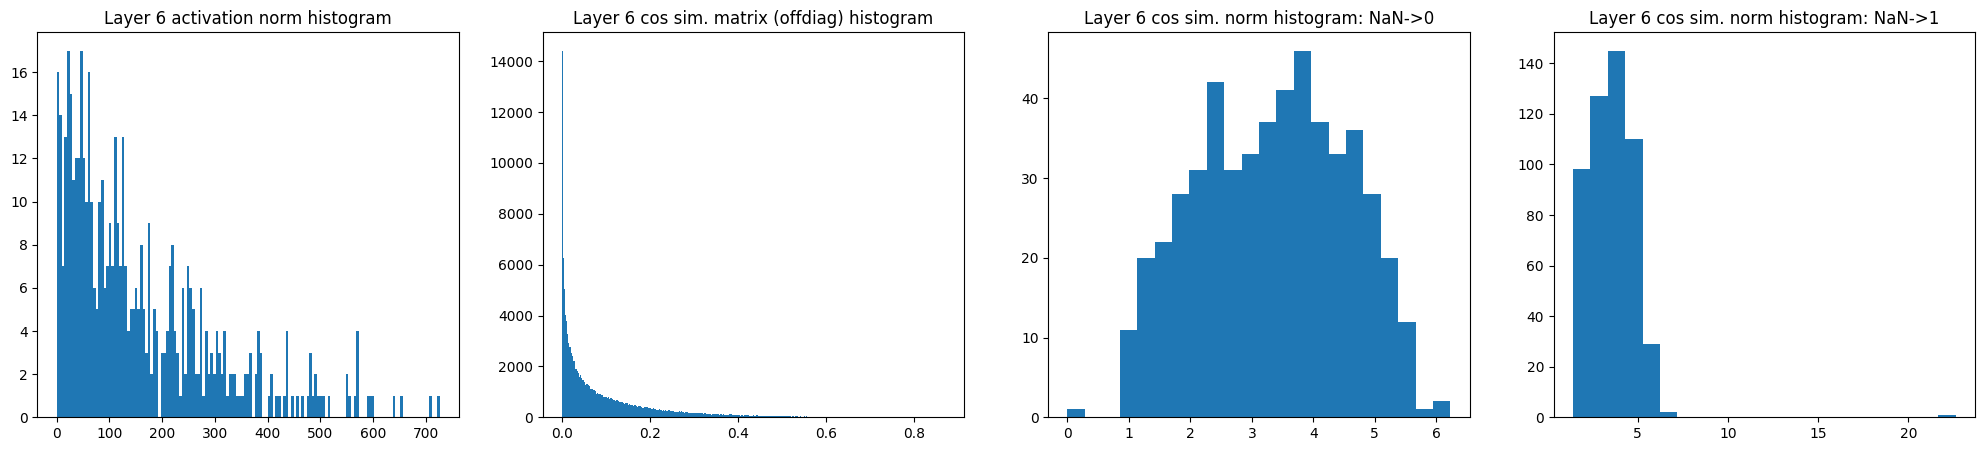

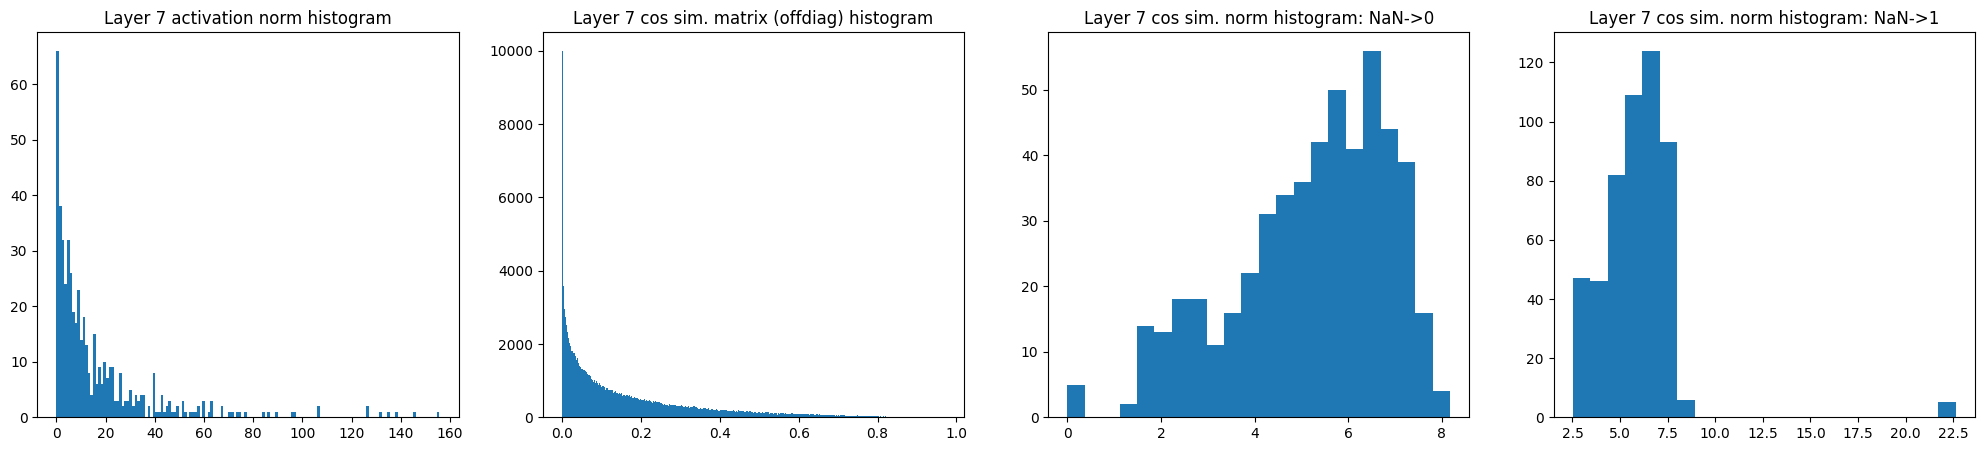

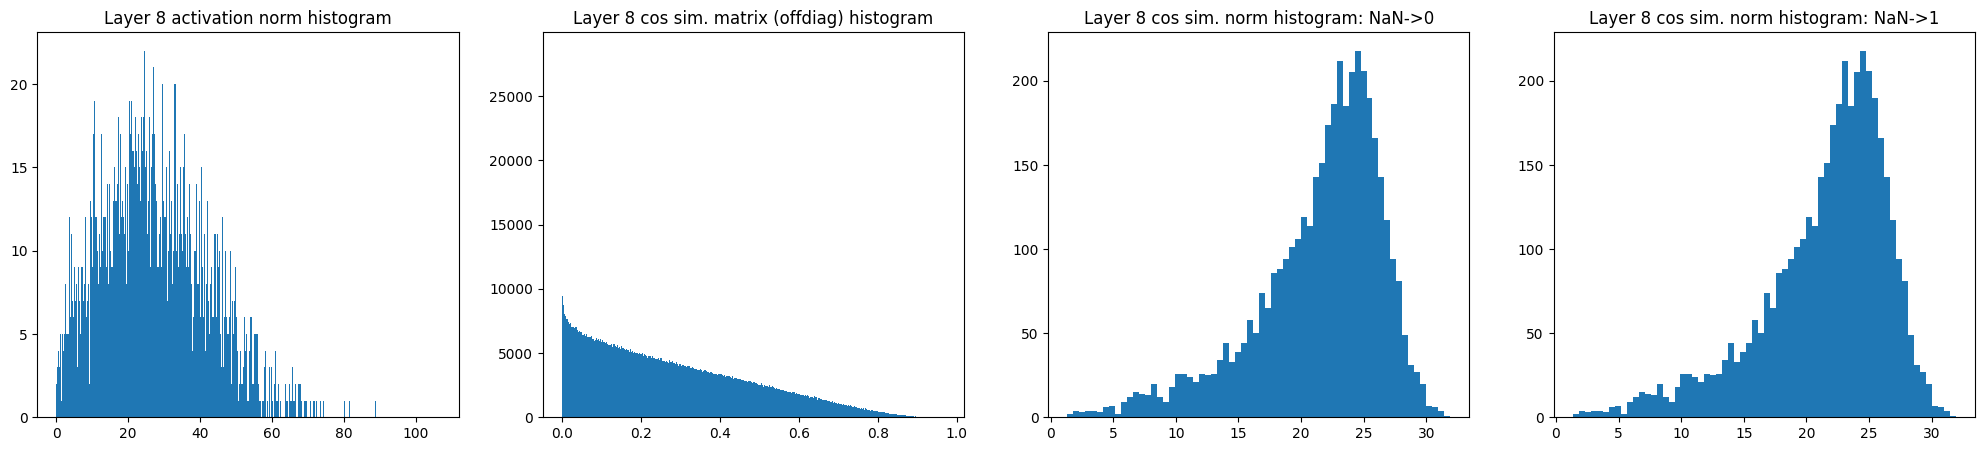

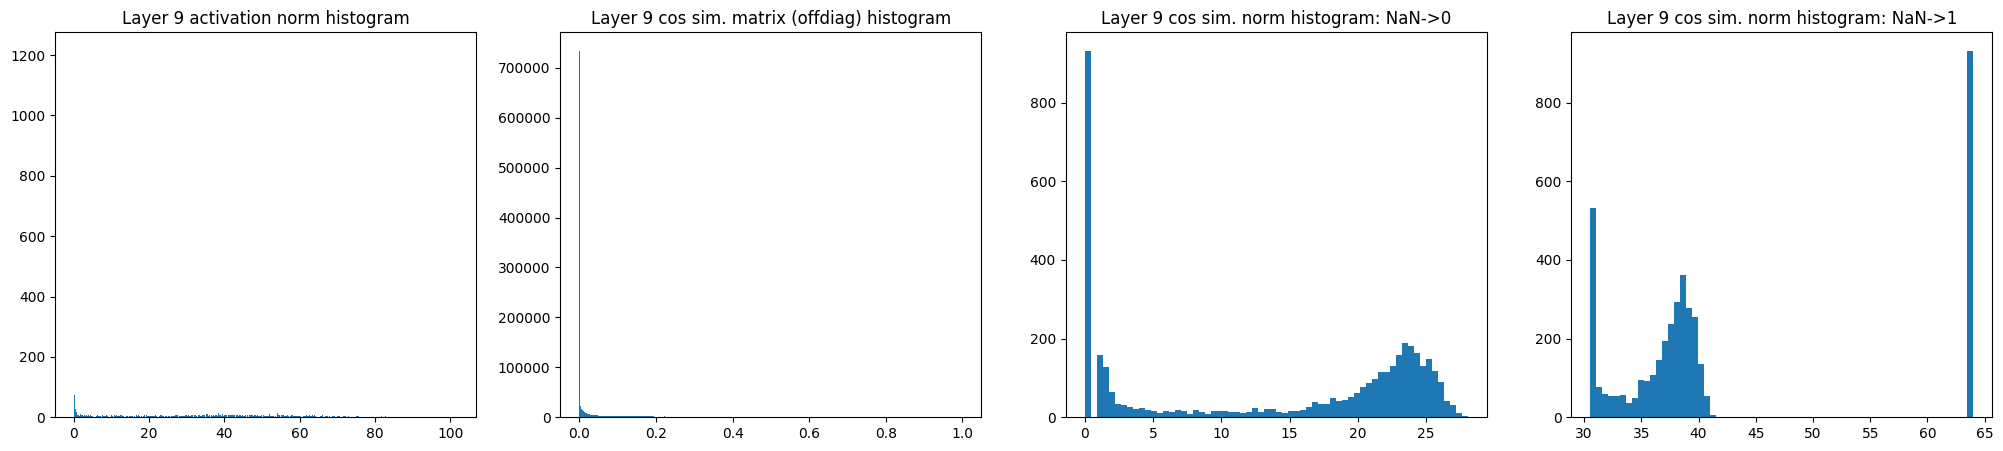

In [11]:
for i in range(len(model)-1):
    activations = torch.Tensor(model.activations[str(i)])
    if len(activations.shape) > 2:
        activations = torch.transpose(torch.transpose(activations, 0, 1).reshape(activations.shape[1], -1), 0, 1)
    inactive = (torch.norm(activations,dim=0)<=1e-4).nonzero(as_tuple=True)
    #activations[:,torch.norm(activations,dim=0)<=1e-4] = 1.0
    norms = torch.norm(activations, dim=0)
    #print(norms)
    activations = activations/norms
    #print(activations[0:20,8])
    corr = activations.t() @ activations
    fig, ax = plt.subplots(1, 4, figsize=(25, 5))
    ax[0].hist(norms[~torch.isnan(norms)].tolist(), bins = int(activations.shape[1]**0.8))
    ax[0].set_title(f"Layer {i} activation norm histogram")
    idx = torch.triu_indices(*corr.shape, offset=1)
    flat = corr[idx[0], idx[1]]
    print((torch.isnan(norms)).nonzero().shape, (torch.isnan(flat)).nonzero().shape)
    ax[1].hist(flat[~torch.isnan(flat)].tolist(), bins = int(idx.shape[1]**0.5))
    ax[1].set_title(f"Layer {i} cos sim. matrix (offdiag) histogram")
    corrnorms1 = torch.norm(torch.nan_to_num(corr, 0), dim=0)
    ax[2].hist(corrnorms1.tolist(), bins = int(corrnorms1.shape[0]**0.5))
    ax[2].set_title(f"Layer {i} cos sim. norm histogram: NaN->0")
    corrnorms2 = torch.norm(torch.nan_to_num(corr, 1), dim=0)
    ax[3].hist(corrnorms2.tolist(), bins = int(corrnorms2.shape[0]**0.5))
    ax[3].set_title(f"Layer {i} cos sim. norm histogram: NaN->1")


In [ ]:
#modded_model_grow = copy.deepcopy(model)
#modded_optimizer_grow = torch.optim.SGD(modded_model_grow.parameters(), lr=0.01)
#modded_optimizer_grow.load_state_dict(optimizer.state_dict())

# modded_model_grow = model
# modded_optimizer_grow = optimizer

# for iter in range(5):
#     for i in range(len(modded_model_grow)-1):
#         max_rank = modded_model_grow[i].out_features if i > modded_model_grow.conversion_layer else modded_model_grow[i].out_channels
#         score = effective_rank(modded_model_grow.activations[str(i)], limit_ratio = 100)
#         num_to_prune = max(int(0.9*init_score[i])-score, 0)
#         scores = svd_score(modded_model_grow.activations[str(i)], limit_ratio = 100)
#         to_prune = np.argsort(scores.cpu().detach().numpy())[:num_to_prune]
#         to_add = max(score-int(0.97*init_score[i]), 0)
#         print("Layer {} score: {}/{}, neurons to prune: {}, # neurons to add: {}".format(i, score, max_rank, to_prune, to_add))
#         modded_model_grow.prune(i, to_prune, optimizer=modded_optimizer_grow)
#         modded_model_grow.grow(i, to_add, fanin_weights="iterative_orthogonalization", 
#                                optimizer=modded_optimizer_grow)
#     print("The modded model now has {} effective parameters.".format(modded_model_grow.parameter_count(masked = True)))
#     print("Validation after growing: ", end = "")
#     test(modded_model_grow, validation_loader, criterion, device=device)
#     train(modded_model_grow, train_loader, modded_optimizer_grow, criterion, epochs=2, val_loader=validation_loader, device=device)

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 2498119335936 bytes. Error code 12 (Cannot allocate memory)